Author: Christopher Z. Eddy (eddyc@ohsu.edu)

## ENVIRONMENT INFO:
Need to use the rapids-22.08 kernel

## NOTES:
This script is only to be used to inspect data before clustering AND to cluster the data using GPU-accelerated Grapheno (Leiden Clustering)

# Load necessary libraries

In [1]:
#This script is made to run on cuda 10.2. You may need to check that the sym-link is right. 
#recommended you check nvidia-smi (returns cuda 11.0 ?)
#and nvcc --version which returns cudatoolkit 10.2

#to change the symlink, see here: https://unix.stackexchange.com/questions/151999/how-to-change-where-a-symlink-points
#ultimately, pretty simple. Just use ln -sfn /usr/local/cuda-11.0 /usr/local/cuda
import os

import pandas as pd
import numpy as np
import cuml

import cudf

import joblib
import time


import grapheno_ce
    
import itertools
import process_data

In [4]:
def is_float(string):
	if string is not None:
		if string.replace(".", "").replace("-","").isnumeric():
			return True
		else:
			return False
	else:
		return False

# Load, Normalize Data (see process_data.py)
The question here is WHEN should we remove outliers. Do we do it BEFORE the embedding? If so, this can result in far better distributions to work with, ones that are not so skewed to one side or another. On the other hand, they may represent unique cell types that should be considered. Or should we remove outliers AFTER the embedding? At least then we have the data for visualization, but the question remains if that effects the embedding itself?

In [6]:
"""
Run the following IF you only wish to retrieve the CSV data as is (no pre-processing).
"""
data = process_data.read_file_CE("/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities.csv", raw=True, write_out_data = False)
## Add any additional columns or potential column names that should NOT be considered during clustering.
bad_cols = [data.columns.tolist()[i] for i,x in enumerate(data.iloc[0].to_pandas().values.flatten()) if not is_float(str(x))] + ['Label', 'cluster', 'MinX','MinY','MaxX','MaxY', 'CentroidX', 'cellid', 'DAPI_X', 'DAPI_Y', 'CentroidY', 'Sample'] + ['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed:0.1', 'Unnamed:0.1.1', 'cell', 'Label', 'MinX', 'MinY', 'MaxX', 'MaxY', 'To Exclude', 'To.Exclude', 'CentroidX', 'CentroidY', 'tissueID', 'patient_ID', 'UMAP1', 'UMAP2', 'TSNE1', 'TSNE2', 'clusters', 'clinical_subtype', 'source', 'scene', 'X']
## WARNING: We will also remove any columns starting with "Q" or "Unnamed". In the ACED/BioLibrary dataset, there are markers associated with each round for registration that begin with the letter "Q" and should not be included in clustering.
bad_cols = bad_cols + [x for x in data.columns.tolist() if (x[0]=="Q") or ("Unnamed" in x)] # or ('DAPI' in x)] #this criteria is not robust, double check it!
bad_cols = list(set(bad_cols))
bad_cols = [x for x in bad_cols if x in data.columns]
good_col_names = [x for x in data.columns.tolist() if np.all([y not in x for y in bad_cols])]
print("GOOD COLUMNS")
print(good_col_names)
print("BAD COLUMNS")
print(bad_cols)

GOOD COLUMNS
['aSMA...Nuclei', 'aSMA...Cells', 'aSMA...Rims', 'aSMA...Rings', 'Tryp...Nuclei', 'Tryp...Cells', 'Tryp...Rims', 'Tryp...Rings', 'Ki67...Nuclei', 'Ki67...Cells', 'Ki67...Rims', 'Ki67...Rings', 'CD68...Nuclei', 'CD68...Cells', 'CD68...Rims', 'CD68...Rings', 'EPCAM...Nuclei', 'EPCAM...Cells', 'EPCAM...Rims', 'EPCAM...Rings', 'AR...Nuclei', 'AR...Cells', 'AR...Rims', 'AR...Rings', 'CD20...Nuclei', 'CD20...Cells', 'CD20...Rims', 'CD20...Rings', 'ChromA...Nuclei', 'ChromA...Cells', 'ChromA...Rims', 'ChromA...Rings', 'CK5...Nuclei', 'CK5...Cells', 'CK5...Rims', 'CK5...Rings', 'CD27...Nuclei', 'CD27...Cells', 'CD27...Rims', 'CD27...Rings', 'HLADRB1...Nuclei', 'HLADRB1...Cells', 'HLADRB1...Rims', 'HLADRB1...Rings', 'CD3...Nuclei', 'CD3...Cells', 'CD3...Rims', 'CD3...Rings', 'R4c2...Nuclei', 'R4c2...Cells', 'R4c2...Rims', 'R4c2...Rings', 'CD11b...Nuclei', 'CD11b...Cells', 'CD11b...Rims', 'CD11b...Rings', 'CD4...Nuclei', 'CD4...Cells', 'CD4...Rims', 'CD4...Rings', 'CD45...Nuclei', '

In [2]:
"""
Run the following IF you only wish to do the normalization on the data and save the output into a NEW csv.
"""
# data = process_data.read_file_CE('/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities.csv', raw=True)
bad_cols = bad_cols = ['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed:0.1', 'Unnamed:0.1.1', 'cell', 'Label', 'MinX', 'MinY', 'MaxX', 'MaxY', 'To Exclude', 'To.Exclude', 'CentroidX', 'CentroidY', 'tissueID', 'patient_ID', 'UMAP1', 'UMAP2', 'TSNE1', 'TSNE2', 'clusters', 'clinical_subtype', 'source', 'scene', 'X']
## WARNING: We will also remove any columns starting with "Q" or "Unnamed". In the ACED/BioLibrary dataset, there are markers associated with each round for registration that begin with the letter "Q" and should not be included in clustering.
bad_cols = bad_cols + [x for x in data.columns.tolist() if (x[0]=="Q") or ("Unnamed" in x)] # or ('DAPI' in x)] #this criteria is not robust, double check it!
bad_cols = list(set(bad_cols)) #form a unique set of bad columns

data, bad_cols = process_data.read_file_CE("/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities.csv", raw=False, write_out_data = True, bad_cols = ['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed:0.1', 'Unnamed:0.1.1', 'cell', 'Label', 'MinX', 'MinY', 'MaxX', 'MaxY', 'To Exclude', 'To.Exclude', 'CentroidX', 'CentroidY', 'tissueID', 'patient_ID', 'UMAP1', 'UMAP2', 'TSNE1', 'TSNE2', 'clusters', 'clinical_subtype', 'source', 'scene', 'X'])
# In the processing step, any additional columns which are not floats are also removed, since they cannot be used for clustering.
good_col_names = [x for x in data.columns.tolist() if np.all([y not in x for y in bad_cols])]
print("GOOD COLUMNS")
print(good_col_names)
print("BAD COLUMNS")
print(bad_cols)

Writing to file : 
/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE.csv
Data shape = (350387, 164)
Converting to cudf
total preprocessing time = 2.049520210425059 minutes
GOOD COLUMNS
['aSMA...Nuclei', 'aSMA...Cells', 'aSMA...Rims', 'aSMA...Rings', 'Tryp...Nuclei', 'Tryp...Cells', 'Tryp...Rims', 'Tryp...Rings', 'Ki67...Nuclei', 'Ki67...Cells', 'Ki67...Rims', 'Ki67...Rings', 'CD68...Nuclei', 'CD68...Cells', 'CD68...Rims', 'CD68...Rings', 'EPCAM...Nuclei', 'EPCAM...Cells', 'EPCAM...Rims', 'EPCAM...Rings', 'AR...Nuclei', 'AR...Cells', 'AR...Rims', 'AR...Rings', 'CD20...Nuclei', 'CD20...Cells', 'CD20...Rims', 'CD20...Rings', 'ChromA...Nuclei', 'ChromA...Cells', 'ChromA...Rims', 'ChromA...Rings', 'CK5...Nuclei', 'CK5...Cells', 'CK5...Rims', 'CK5...Rings', 'CD27...Nuclei', 'CD27...Cells', 'CD27...Rims', 'CD27...Rings', 'HLADRB1...Nuclei', 'HLADRB1...Cells', 'HLADRB1...Rims', 'HLADRB1...Rings', 'CD3...Nuclei', 'C

In [ ]:
print(good_col_names)

In [6]:
data.head()

,AR_nuclei,CDX2_nuclei,DAPI0Q_nuclei,DAPI1_nuclei,DAPI10_nuclei,DAPI10Q_nuclei,DAPI2_nuclei,DAPI3_nuclei,DAPI3Q_nuclei,DAPI4_nuclei,...,EPCAM_negative,CK5_negative,CD45_negative,ECAD_negative,CK14_negative,CD3_negative,CK8_negative,DAPI_Y,DAPI_X,cellid
0,0.000565,0.048366,0.064928,0.508551,0.166479,0.195218,0.556189,0.437165,0.366897,0.333746,...,True,True,True,True,True,True,True,502.833333,2078.476190,10
1,0.022834,0.018278,0.027959,0.130511,0.032258,0.045887,0.162524,0.153028,0.126547,0.115608,...,True,True,True,True,True,True,True,509.565789,2097.236842,11
2,0.029728,0.050409,0.010839,0.261432,0.077610,0.114647,0.318494,0.193264,0.142312,0.195211,...,True,True,True,True,True,True,True,514.518519,2046.629630,13
3,0.011850,0.015332,0.293507,0.234158,0.074596,0.086951,0.258776,0.189232,0.138662,0.162826,...,True,True,False,True,True,False,True,555.624146,1979.712984,24
4,0.011472,0.037090,0.159191,0.378503,0.115106,0.151129,0.414319,0.345720,0.263886,0.239661,...,True,True,True,True,True,True,True,567.159645,1789.324834,27


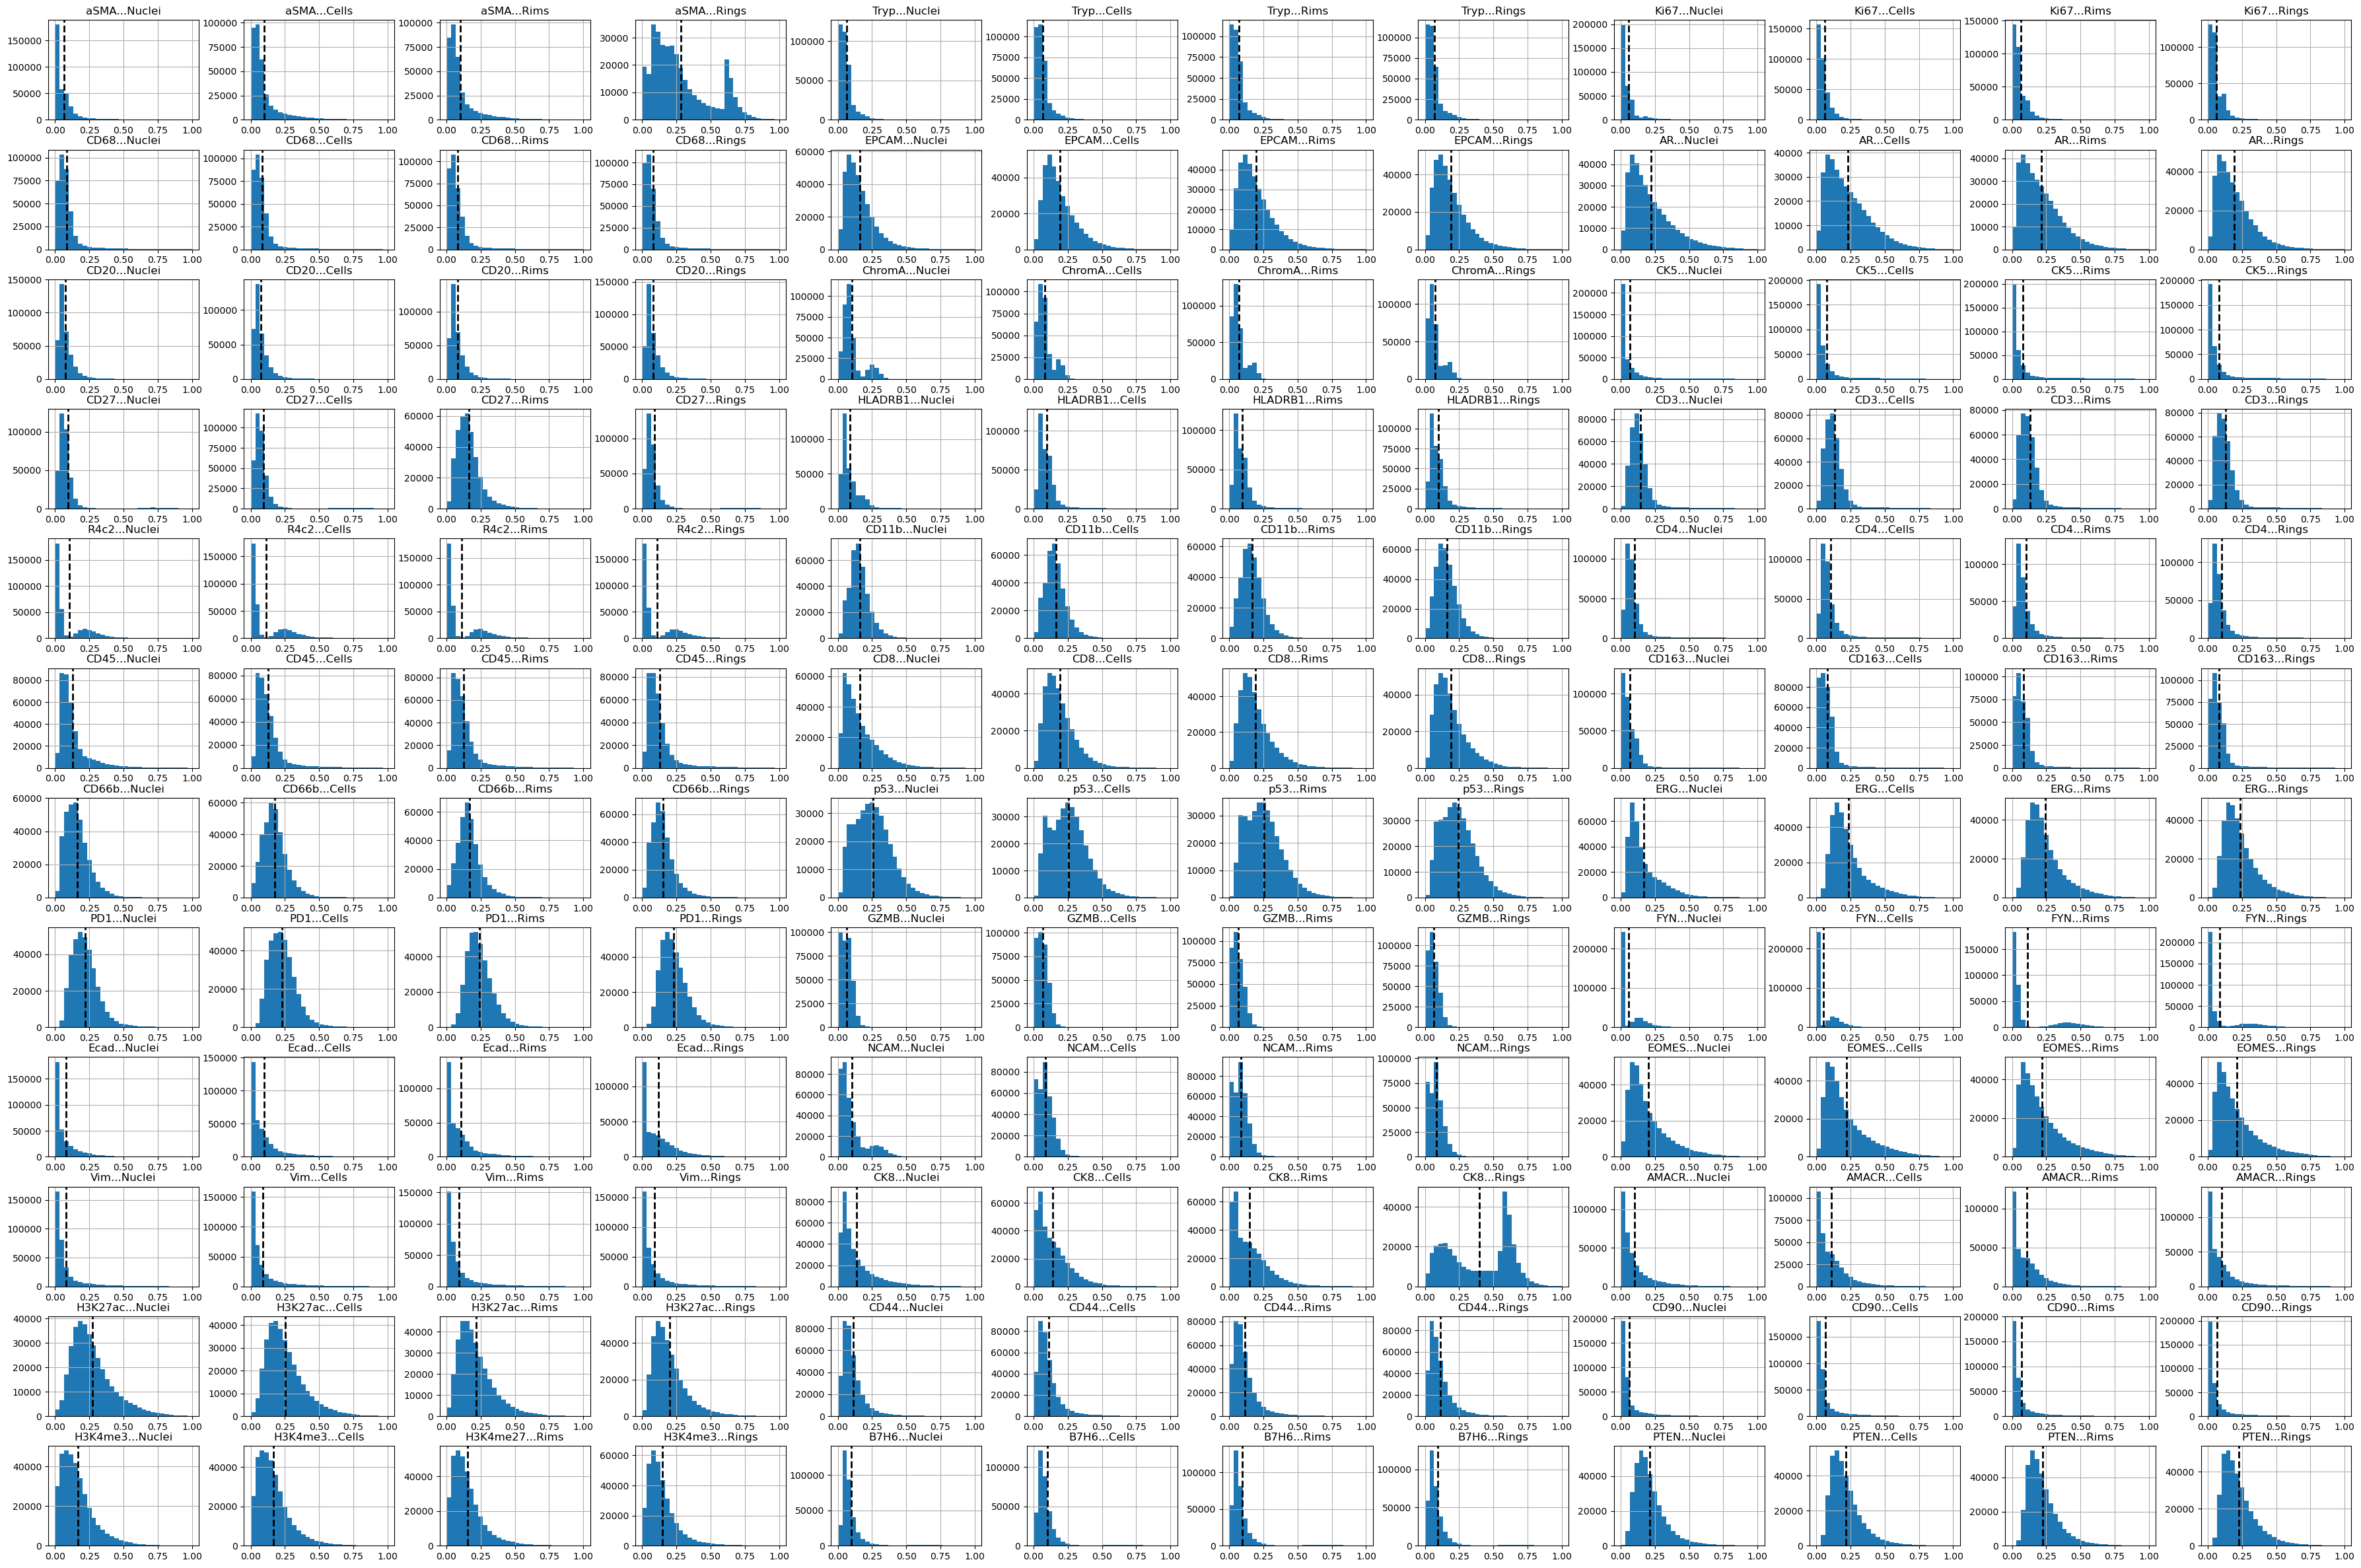

In [3]:
"""
Visualize the histogram data
"""
#process_data.visualize_hists(data, save_fig=True, figname="/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/scripts/CE_v2_Processed.pdf")
#good_col_names = [x for x in data.columns.tolist() if np.all([y not in x for y in bad_cols])]
process_data.visualize_hists(data[good_col_names],plot_mean=True)

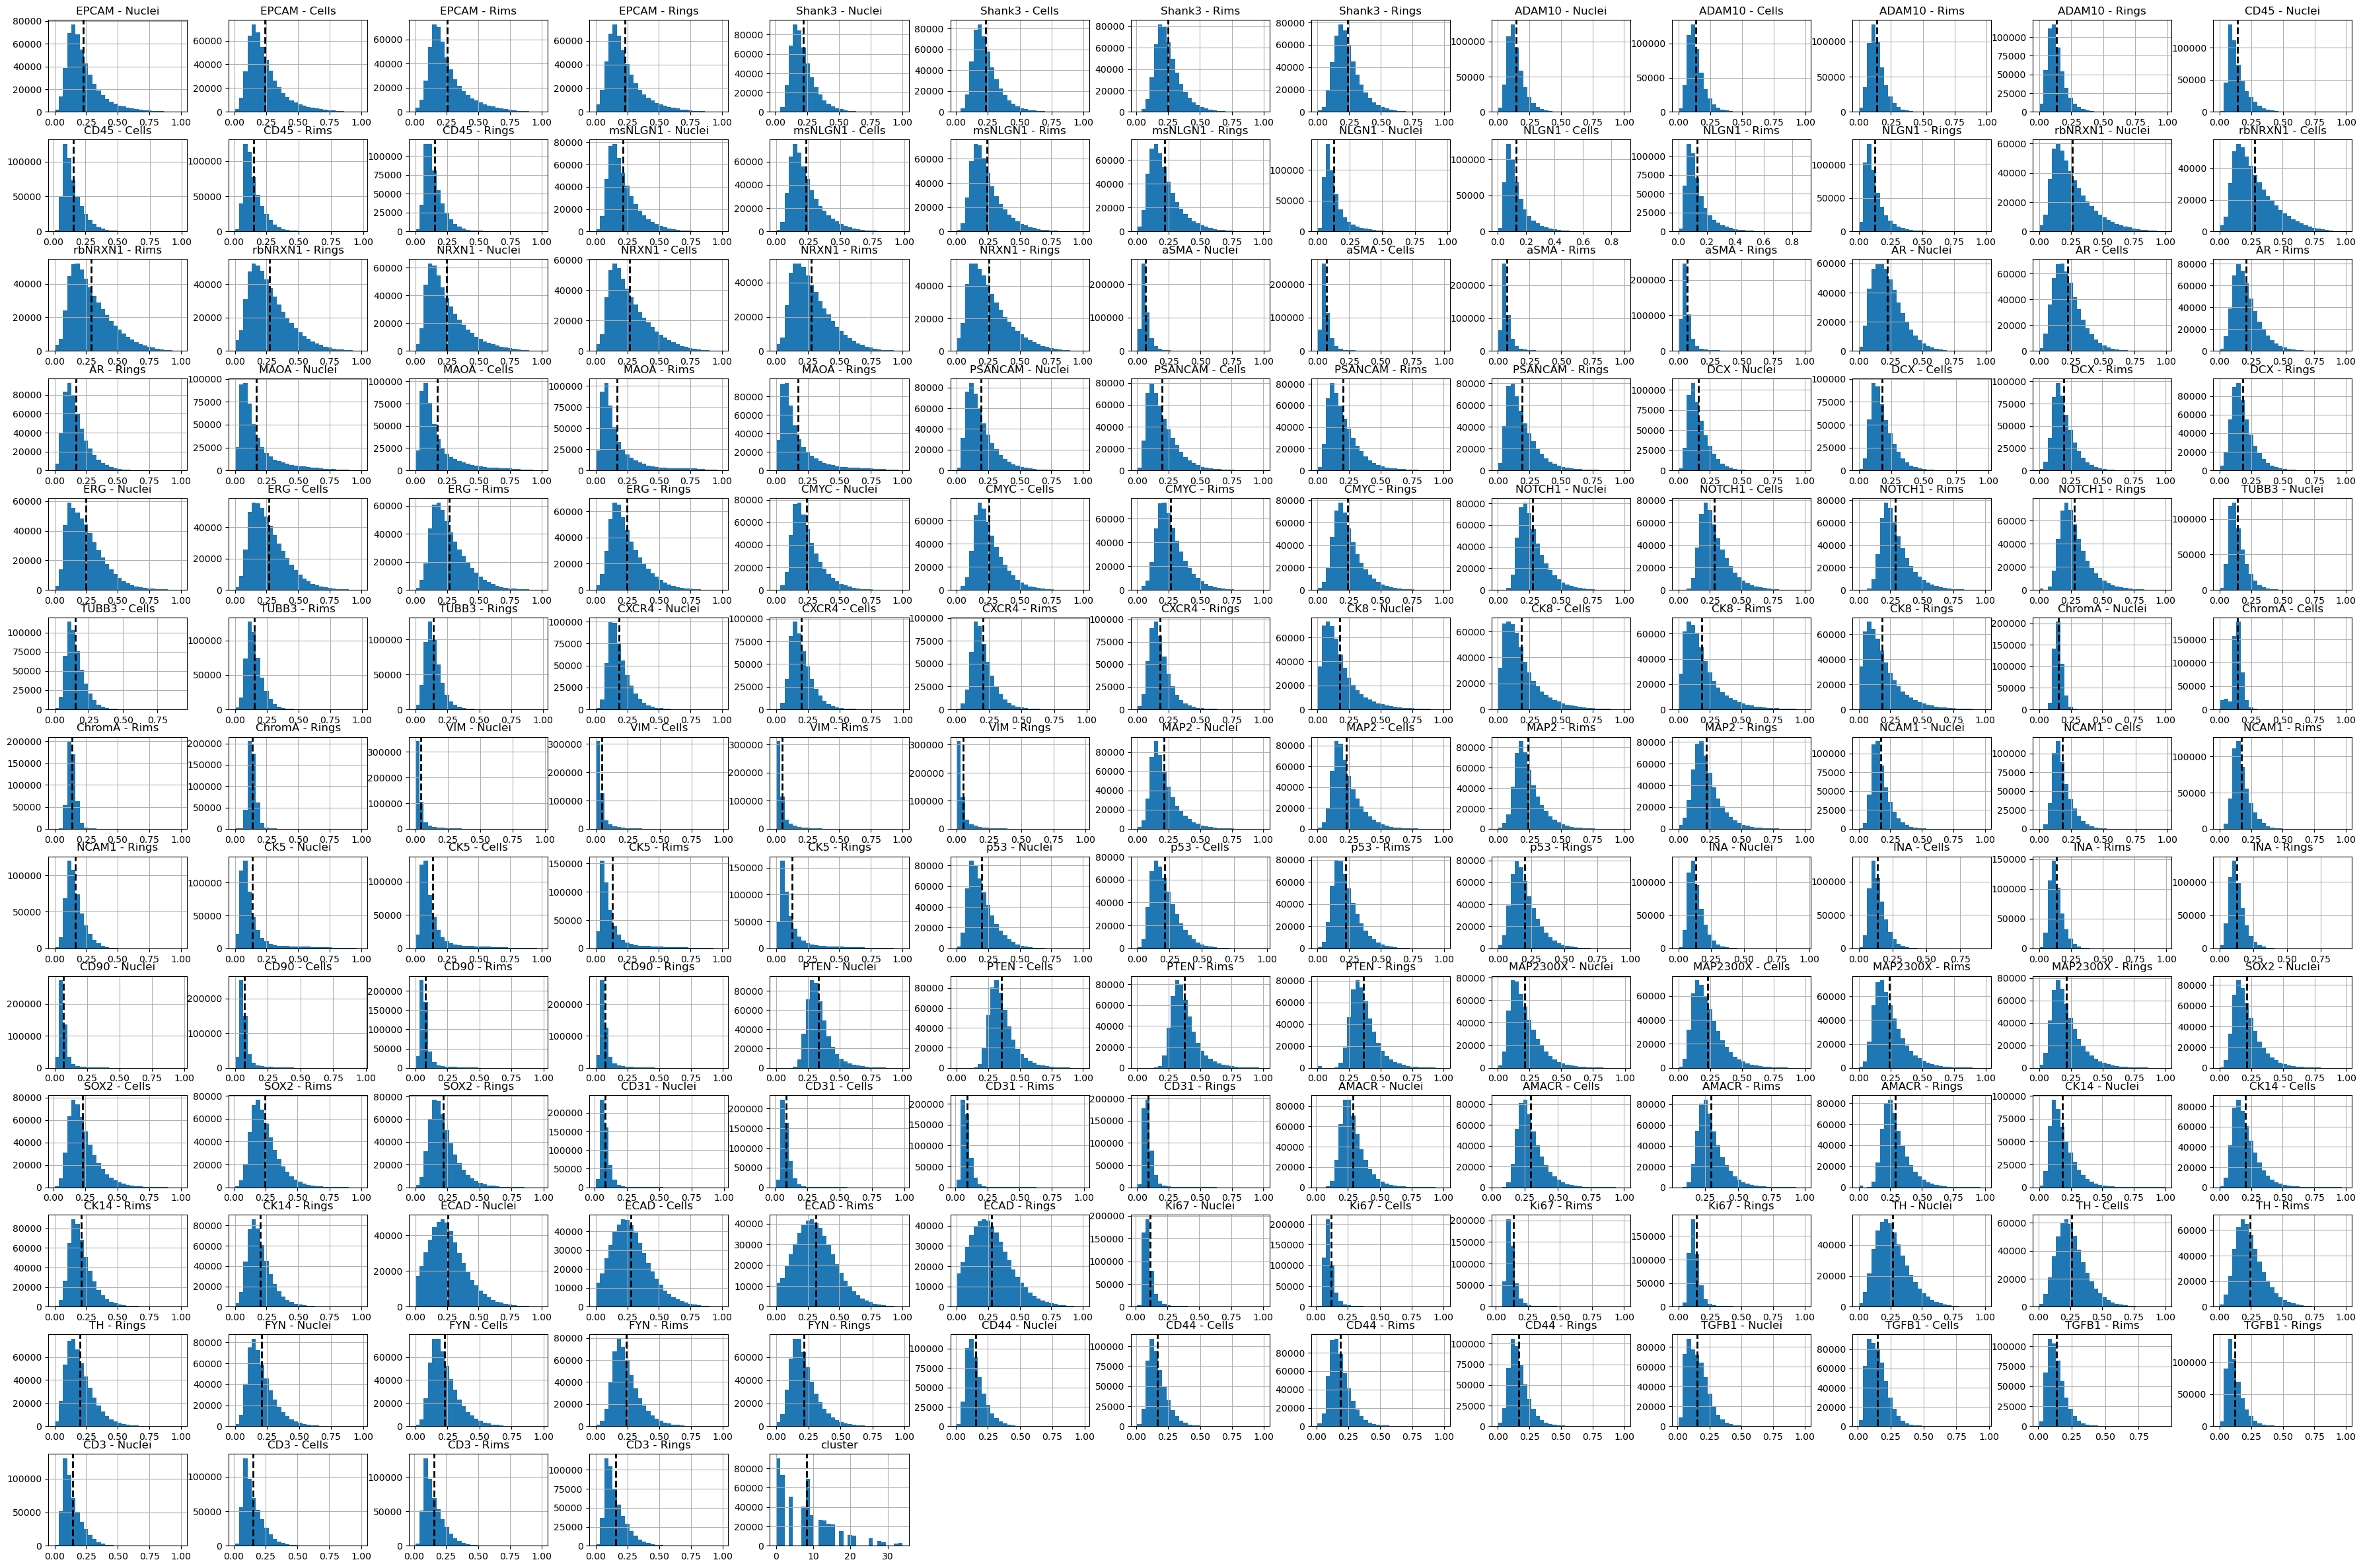

In [7]:
# process_data.visualize_hists(data.loc[data["Sample"].str.contains('17633-scene0-3')],plot_mean=True)
process_data.visualize_hists(data,plot_mean=True)

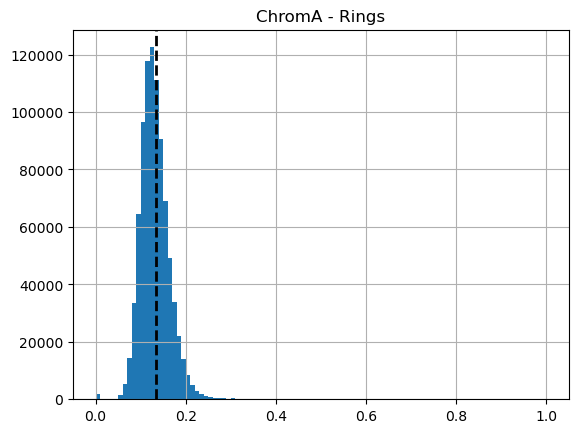

In [8]:
process_data.visualize_hists(data,'ChromA - Rings',plot_mean = True)

In [1]:
process_data.visualize_hists(df,'MAOA - Rings')

NameError: name 'process_data' is not defined

It is important to visualize the distributions at this stage. They should appear approximately normal, or at least log-normal. For example, the histogram plot of TGFB1 - Rings looks like 
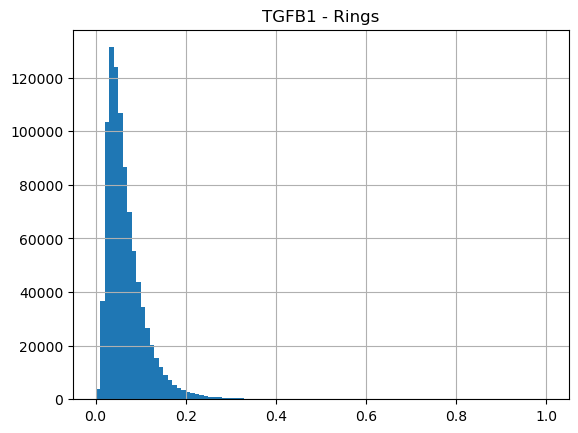

There are several different ways CuPy can be installed, but the wrong install may cause a poor time performance. The following is an example of a good install using Python 3.8

OS                           : Linux-3.10.0-1062.18.1.el7.x86_64-x86_64-with-glibc2.17
CuPy Version                 : 8.6.0
NumPy Version                : 1.23.3
SciPy Version                : 1.9.1
Cython Build Version         : 0.29.22
CUDA Root                    : /usr/local/cuda
CUDA Build Version           : 10020
CUDA Driver Version          : 11000
CUDA Runtime Version         : 10020
cuBLAS Version               : 10202
cuFFT Version                : 10102
cuRAND Version               : 10102
cuSOLVER Version             : (10, 3, 0)
cuSPARSE Version             : 10301
NVRTC Version                : (10, 2)
Thrust Version               : 100907
CUB Build Version            : <unknown>
cuDNN Build Version          : 8100
cuDNN Version                : 8201
NCCL Build Version           : 2804
NCCL Runtime Version         : 21403
cuTENSOR Version             : 10202
Device 0 Name                : GeForce RTX 2080 Ti
Device 0 Compute Capability  : 75

In [2]:
import cupy
cupy.show_config()

OS                           : Linux-3.10.0-1062.18.1.el7.x86_64-x86_64-with-glibc2.17
Python Version               : 3.9.15
CuPy Version                 : 10.6.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.22.4
SciPy Version                : 1.9.3
Cython Build Version         : 0.29.30
Cython Runtime Version       : None
CUDA Root                    : /usr/local/cuda
nvcc PATH                    : /usr/local/cuda/bin/nvcc
CUDA Build Version           : 11020
CUDA Driver Version          : 11000
CUDA Runtime Version         : 11070
cuBLAS Version               : (available)
cuFFT Version                : 10702
cuRAND Version               : 10210
cuSOLVER Version             : (11, 3, 5)
cuSPARSE Version             : (available)
NVRTC Version                : (11, 7)
Thrust Version               : 101000
CUB Build Version            : 101000
Jitify Build Version         : 87d8ccd
cuDNN Build Version          : None
cuDNN Version                : None
NC

# See HERE for PCA REDUCTION

In [ ]:
ml_PCA = cuml.PCA(n_components=len(good_col_names), whiten=True).fit(data[good_col_names])
trans_df = ml_PCA.transform(data[good_col_names])
#remove first N components; typically, the first component may capture batch information. But one should do the analysis first to find if this is true.
N = 1
trans_df = trans_df[list(range(trans_df.shape[1])[N:])]
trans_df.columns = trans_df.columns.astype(str)
trans_df.head()

In [ ]:
# should likely write it out to a file to be used later

# SEE HERE FOR CLUSTERING

## Replacing Eric's Louvain classification, since grapheno doesn't work.
https://docs.rapids.ai/api/cugraph/stable/api_docs/api/cugraph.louvain.html

Eric's code is expecting you to load the CSV at this point, meaning we should save the normalized data as it is now. 
In the future, we could edit the code to pass the cudf dataframe, but the beauty in how this is currently setup is we can use dask to load in portions of the data into memory at a time instead of the whole thing. 


In [4]:
"""
IF YOU ARE DOING CLUSTERING ON THE WHOLE DATASET, DO THIS!
"""
#import grapheno_ce
#toy data. Pass feature strings in second argument. 
#so first, do clustering. 
#good_col_names = pd.read_csv('/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE.csv', index_col=0, nrows=0).columns.tolist()[:-1] #exclude 'Sample'
df = grapheno_ce.cluster('/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE.csv', 
                      good_col_names,
                      n_neighbors=20,
                      distributed_knn = True,
                      distributed_graphs = False,
                      min_size=1000) #the data size is ~1M cells. The rare cell subtype is approx 1% of all cells.
#df is the new dataframe which, in addition to 'Sample', now has the column 'cluster'

Computing and caching 20NN edgelist: BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE_20NN_edgelist.parquet
20NN edgelist computed and cached in 14.86 seconds...
Computing and caching jaccard edgelist: BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE_20NN_edgelist_jaccard.parquet
Jaccard graph computed, cached, and reloaded in 1.33 seconds...
Computing Leiden clustering over Jaccard graph...
Leiden clustering completed in 0.80 seconds...
Clusters detected: 44
Clusters modularity: 0.9385613203048706
Writing output dataframe: /home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE_20NN_leiden.parquet
Grapheno completed in 21.24 seconds!


In [2]:
"""
IF clustering has been done, then the data has been saved already as a parquet filetype, or it will be automatically loaded since it was cached.
"""
df = cudf.read_parquet('/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Neuronal_Normalized_Mean_Intensities_processed_robust_CE_processed_robust_CE_20NN_leiden.parquet')



In [5]:
"""
Convert the auto-saved parquet file into a CSV file (if you want). 
"""
df.to_csv("/home/groups/CEDAR/eddyc/projects/cyc_IF/DTRON2/data/classification/BioLib_Immune_Normalized_Mean_Intensities_processed_robust_CE_20NN_leiden.csv",index=False)
#exclude the index



In [13]:
df.head()

,AR_nuclei,CDX2_nuclei,DAPI0Q_nuclei,DAPI1_nuclei,DAPI10_nuclei,DAPI10Q_nuclei,DAPI2_nuclei,DAPI3_nuclei,DAPI3Q_nuclei,DAPI4_nuclei,...,CK5_negative,CD45_negative,ECAD_negative,CK14_negative,CD3_negative,CK8_negative,DAPI_Y,DAPI_X,cellid,cluster
0,0.000565,0.048366,0.064928,0.508551,0.166479,0.195218,0.556189,0.437165,0.366897,0.333746,...,True,True,True,True,True,True,502.833333,2078.476190,10,2
1,0.022834,0.018278,0.027959,0.130511,0.032258,0.045887,0.162524,0.153028,0.126547,0.115608,...,True,True,True,True,True,True,509.565789,2097.236842,11,12
2,0.029728,0.050409,0.010839,0.261432,0.077610,0.114647,0.318494,0.193264,0.142312,0.195211,...,True,True,True,True,True,True,514.518519,2046.629630,13,12
3,0.011850,0.015332,0.293507,0.234158,0.074596,0.086951,0.258776,0.189232,0.138662,0.162826,...,True,False,True,True,False,True,555.624146,1979.712984,24,2
4,0.011472,0.037090,0.159191,0.378503,0.115106,0.151129,0.414319,0.345720,0.263886,0.239661,...,True,True,True,True,True,True,567.159645,1789.324834,27,2


======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

========================================================================================================================================================================================================================================================================================================================================================================================

# REGROUP BY CLUSTER TYPE -- Subclustering
Ece has sent the following information, for which we need to regroup cells:

Epithelial clusters: 8, 15, 7, 4, 10, 18, 32, 20, 34, 0, 2, 28 12, 9, 33, 13, 14 
 
Stromal-neuronal clusters: 27, 24, 19, 26, 31, 23, 35 
 
Stromal-regular clusters: 22, 1, 3, 16, 6 
 
Immune clusters: 5, 17, 11 
 
Ki67 positive cells formed a separate cluster = cluster 21 (we may need to include this cluster in all separate cell-type specific analyses) 
 
May be autofluorescence, cells that fell out of the tissue, other artifacts. We need to check which samples these cells come from and manually confirm their presence on the image for further clues: 29, 25 

In [3]:
#NOTE: Groups correspond to 'cluster' from file: 
#/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE.csv
# names = ['epithelial', 'stromal-neuronal', 'stromal-regular', 'immune']
# grps = [[8, 15, 7, 4, 10, 18, 32, 20, 34, 0, 2, 28, 12, 9, 33, 13, 14, 21, 29, 25], 
#         [27, 24, 19, 26, 31, 23, 35, 21, 29, 25],
#         [22, 1, 3, 16, 6, 21, 29, 25],
#         [5, 17, 11, 21, 29, 25]]
names = ['ki67']
grps = [[21]]


In [4]:
df_subgroups = {name: df.loc[df['cluster'].to_pandas().isin(x)] for name,x in zip(names, grps)}

In [5]:
for name in names:
    print("{}: shape = {}, N_clusters = {}".format(name,df_subgroups[name].shape, len(df_subgroups[name]['cluster'].unique())))

ki67: shape = (10312, 162), N_clusters = 1


In [7]:
#write each subgroup to csv
for name in df_subgroups:
    print("Reading {}".format(name))
    #save data to parquet
    out_csv_path = '/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE_{}.csv'.format(name)
    df_subgroups[name].to_csv(out_csv_path, index = True) #write index to the zeroth column.

Reading ki67


### RUN HERE TO DO CLUSTERING AND SAVE PARQUET/CSV FILES

In [8]:
for name in df_subgroups:
    print("Reading {}".format(name))
    out_csv_path = '/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE_{}.csv'.format(name)
    _ = grapheno_ce.cluster(out_csv_path, 
                      good_col_names,
                      n_neighbors=20,
                      distributed_knn = True,
                      distributed_graphs = False,
                      index_col = 0,
                      new_column_name = 'subcluster',
                      overwrite = False,
                      min_size=100) #the data size is ~1M cells. The rare cell subtype is approx 1% of all cells.

### NOTE ON MIN_SIZE: If the data size is ~1M cells, the rare cell subtype is approximately 1% of all cells. So setting this to 1000 would work.


Reading ki67
Computing and caching 20NN edgelist: Normalized Mean Intensities_processed_robust_CE_ki67_20NN_edgelist.parquet
20NN edgelist computed and cached in 3.93 seconds...
Computing and caching jaccard edgelist: Normalized Mean Intensities_processed_robust_CE_ki67_20NN_edgelist_jaccard.parquet
Jaccard graph computed, cached, and reloaded in 0.39 seconds...
Computing Leiden clustering over Jaccard graph...
Leiden clustering completed in 0.04 seconds...
Clusters detected: 15
Clusters modularity: 0.7700499296188354
Writing output dataframe: /home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE_ki67_20NN_leiden.parquet
Grapheno completed in 4.72 seconds!


### RUN HERE WHEN ALREADY CLUSTERED TO LOAD THE DATA AGAIN

In [9]:
df_subgroups = {}
for name in names:
    print("Reading {}".format(name))
    #save data to parquet
    out_parquet_path = '/home/groups/CEDAR/eddyc/projects/cyc_IF/UMAP/data/Normalized Mean Intensities_processed_robust_CE_{}_20NN_leiden.parquet'.format(name)
    df_subgroups.update({name: cudf.read_parquet(out_parquet_path)})
    

Reading ki67


In [10]:
for name in names:
    print("{}: shape = {}, N_clusters = {}".format(name,df_subgroups[name].shape, len(df_subgroups[name]['cluster'].unique())))
    

ki67: shape = (10312, 163), N_clusters = 1


In [11]:
df_subgroups['ki67'].head() #make sure this looks right, otherwise you need to redo clustering.

,EPCAM - Nuclei,EPCAM - Cells,EPCAM - Rims,EPCAM - Rings,Shank3 - Nuclei,Shank3 - Cells,Shank3 - Rims,Shank3 - Rings,ADAM10 - Nuclei,ADAM10 - Cells,...,TGFB1 - Cells,TGFB1 - Rims,TGFB1 - Rings,CD3 - Nuclei,CD3 - Cells,CD3 - Rims,CD3 - Rings,Sample,cluster,subcluster
1269,0.187391,0.210547,0.339734,0.301221,0.094474,0.131087,0.160341,0.151605,0.078806,0.068908,...,0.134261,0.116552,0.149903,0.117573,0.101726,0.111478,0.120485,17633-scene0-3,21,-1
1345,0.189796,0.240139,0.267661,0.282490,0.194333,0.233050,0.269991,0.265104,0.140469,0.150203,...,0.147253,0.107614,0.102686,0.164121,0.128991,0.120652,0.132140,17633-scene0-3,21,1
2319,0.189351,0.198207,0.237255,0.195572,0.233630,0.216995,0.240618,0.198981,0.132493,0.113786,...,0.105258,0.064056,0.054925,0.113532,0.083261,0.076583,0.076719,17633-scene0-3,21,3
2970,0.278433,0.220510,0.179955,0.184470,0.321874,0.276655,0.212988,0.261540,0.136172,0.099501,...,0.169488,0.104874,0.132363,0.221999,0.165974,0.143704,0.162766,17633-scene0-3,21,-1
3127,0.453845,0.526316,0.545160,0.508739,0.371305,0.501584,0.505947,0.555424,0.200786,0.240959,...,0.149836,0.130221,0.146187,0.150044,0.144954,0.141556,0.151236,17633-scene0-3,21,1


# Now, jump over to visualize_grapheno_clustering.ipynb to see your clusters!

Author: Christopher Z. Eddy (eddyc@ohsu.edu)
